In [23]:
from scipy.integrate import odeint
from plotting import *
from functions import *
from coupling_analysis import get_pphases

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 5000
point_dens = 40 # points per time unit
numpoints = int(point_dens * stoptime)
filename = 'macierz.txt'


def synchrograms_from_file():
    w0, p, couplings_gl = load_params(file='IO/'+filename) # load params from file
    n = int(len(w0)/2)
    q = dynamics(n, w0, p, couplings_gl, N=1, M=1, plot=False, save=True)
    print("synchro:", q)


def dynamics(n, w0, p, couplings_gl, N=1, M=1, plot=False, save=False):
    t = np.array([stoptime * float(i) / (numpoints - 1) for i in range(numpoints)])

    # Call the ODE solver.
    wsol, dict = odeint(vector_field, w0, t, args=(p,),
                  atol=abserr, rtol=relerr, full_output=True)
    # ttt=np.round(dict['hu'], 3)
    # print(np.round(list(set(ttt)), 3))

    # cut unstable points
    t = t[point_dens * 221:]
    wsol = wsol[point_dens * 221:, :]

    plot_params = {'figure.figsize': (12, 10),
                   'axes.labelsize': 'medium',
                   'axes.titlesize': 'medium',
                   'xtick.labelsize': 'xx-small',
                   'ytick.labelsize': 'xx-small'}
    plt.rcParams.update(plot_params)

    t, wsol, pphases = get_pphases(t, wsol, cut=point_dens * 10)

    if save:
        t = np.transpose([t])
        np.savetxt('IO/signal.txt', np.hstack((t,wsol)), fmt='%.18g', delimiter=' ', newline='\n')


    #qcoeff1, qcoeff2 = fourier_coeff(phases, ph_diff)

    if plot:
        timeSeries(t, wsol, n, p, pphases)

    # synchrogramy
    any_coupling = False
    for c in couplings_gl:
        if len(c[1]) > 0:
            any_coupling = True
    if any_coupling:
        if plot:
            plot_synchrograms(t, pphases, couplings_gl)
        qq = synchronization(pphases, couplings_gl, N, M)
        return qq

In [24]:
def vector_field(w, t, p):
    """
        w :  vector of the state variables: w = [x1,y1,x2,y2,...]
        p = [alfa1, mi1, d1, e1, k1, alfa2, mi2, d2, e2, k2, ...]
        y: initial derrivative at x
        d: -saddle
        e: -node
          dx/dt = y
          dy/dt = -alfa(x^2 - mi)y - f*x(x+d)(x+e) = 0
    """

    # Create equasions = (x1',y1',x2',y2'):
    equasions = []
    y = w[1::2]
    x = w[0::2]
    for o in range(0, int(len(w)/2)):
        equasions.append(y[o])
        params = {'alfa': p[o][0], 'mi': p[o][1], 'd': p[o][2], 'e': p[o][3], 'f': p[o][4]}

        # passed frequency has to be calculated to parameter f:
        params['f'] = 29.3*params['f']**2
        couplings = p[o][5:]
        couplings = list(zip(couplings[0::2], couplings[1::2]))
        eq = -1 * params['alfa'] * (x[o] ** 2 - params['mi']) * \
             y[o] - params['f'] * x[o] * (x[o] + params['d']) * (x[o] + params['e'])
        for c in couplings:
            drive_osc = int(c[0])
            k = c[1]
            eq += k * (x[drive_osc] + y[drive_osc]) + 0.5*np.random.normal()
        equasions.append(eq)
    return equasions

In [25]:
synchrograms_from_file()

synchro: None


In [26]:
from coupling_analysis import natural_freq, true_phases

In [27]:
data = np.loadtxt('IO/signal.txt')
t = data[:, 0]
wsol = data[:, 1:]
fs = 1 / (t[1] - t[0])

X = wsol[:, 0::2]
Y = wsol[:, 1::2]
N = X.shape[1]

# normal
theta = -np.arctan2(Y, X)

# noisy
# theta = -np.arctan2(Y - 0.2 + np.random.uniform(-0.05, 0.05), X - 0.2 + np.random.uniform(-0.05, 0.05))
# np.savetxt('IO/theta.txt', theta)

omega = natural_freq(t, theta)
print(omega)

ph = true_phases(theta.T)

[ 5.26523054]


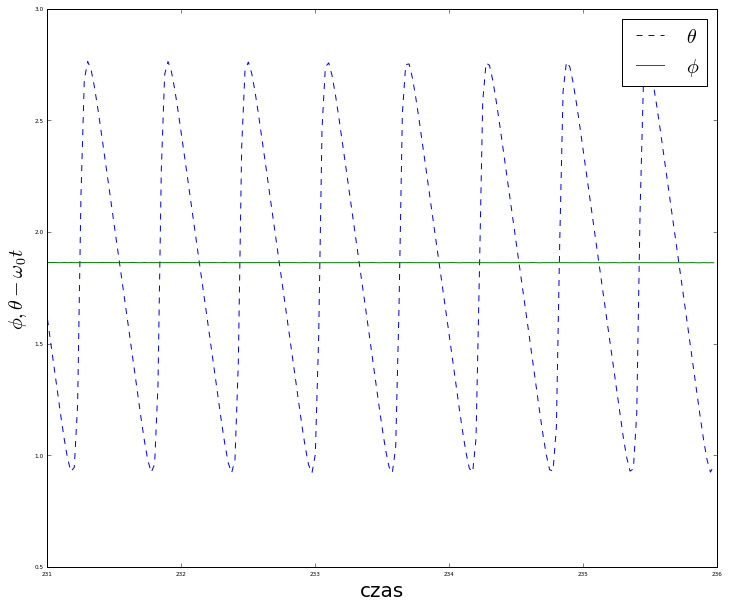

In [28]:
plt.plot(t[:200], np.unwrap(theta[:200, 0]) - omega*(t[:200]-t[0]), linestyle='--', label=r"$\theta$")
plt.plot(t[:200], np.unwrap(ph[0][:200]) - omega*(t[:200]-t[0]), label=r"$\phi$")
plt.xlabel("czas", fontsize=20)
plt.ylabel(r"$\phi, \theta - \omega_0 t$", fontsize=20)
plt.legend(fontsize=20)
plt.savefig("IO/phi_theta.png")
plt.show()